In [188]:
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
%matplotlib inline

In [2]:
bsz = 10

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=bsz, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
batch_size=bsz, shuffle=True)

    4     2     5     0


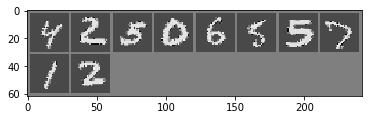

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = list(range(10))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [263]:
class Leaf(nn.Module):
    def __init__(self, i_size, o_size, h_size=128):
        super(Leaf, self).__init__()
        self.i2h = nn.Linear(i_size, h_size)
        self.h2o = nn.Linear(h_size, o_size)
        self.soft = nn.LogSoftmax(1)
        self.relu = nn.ReLU()
        self.is_leaf = True

    def forward(self, features):
        out = self.i2h(features)
        out = self.relu(out)
        out = self.h2o(out)
        return self.soft(out)

    def accum_probs(self, features, path_prob):
        return [[path_prob, self.forward(features)]]

class Node(nn.Module):
    def __init__(self, i_size, o_size):
        super(Node, self).__init__()
        self.o_size = o_size
        self.i_size = i_size
        self.i2o = nn.Linear(i_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.is_leaf = False
    
    def build_tree(self, depth):
        if depth < 0:
            raise NotImplementedError
        if depth - 1 > 0:
            self.left = Node(self.i_size, self.o_size)
            self.right = Node(self.i_size, self.o_size)
            self.left.build_tree(depth - 1)
            self.right.build_tree(depth - 1)
        else:
            self.left = Leaf(self.i_size, self.o_size)
            self.right = Leaf(self.i_size, self.o_size)

    def forward(self, features):
        pr = self.prob_left(features)
        return pr*self.left(features) + (1 - pr)*self.right(features)

    def prob_left(self, features):
        return self.sigmoid(self.i2o(features))

    def accum_probs(self, features, path_prob):
        res = []
        p_l = self.sigmoid(self.i2o(features))
        res_l = self.left.accum_probs(features, p_l*path_prob)
        res_r = self.right.accum_probs(features, (1 - p_l)*path_prob)
        res.extend(res_l)
        res.extend(res_r)
        return res

def tree_loss(path_probs, y_true):
    loss = 0
    criterion = nn.NLLLoss()
    for p, pred in path_probs:
        loss += p*criterion(pred, y_true)
    return loss.mean()

def tree_logloss(path_probs, y_true):
    """
    Original loss from paper
    """
    loss = 0
    criterion = nn.NLLLoss()
    for p, pred in path_probs:
        loss -= p*criterion(pred, y_true)
    return -torch.log(loss.mean())

In [264]:
net = Node(28*28, 10)

In [265]:
net.build_tree(2)

In [216]:
optimizer = optim.Adam(net.parameters())
all_loss = np.zeros(200)
criterion = nn.NLLLoss()
for epoch in range(5):
    print(epoch)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        features, targets = batch
        features = Variable(features.view(-1, 28*28))
        targets = Variable(targets)
        #out = net(features)
        loss = tree_loss(net.accum_probs(features, 1), targets)
        loss.backward()
        optimizer.step()
        all_loss[i%200] = loss.data[0]
        if i % 500 == 0:
            print(all_loss.max(), all_loss.mean())

0
0.04448346048593521 0.00022241730242967606
1.02219557762146 0.08888920063320256
1.451016902923584 0.08958627382096893
0.7898892164230347 0.07377105898632635
0.8192051649093628 0.09002668988283404
1.0244543552398682 0.09055522648563055
0.8202686309814453 0.06427575424821043
1.0864510536193848 0.06934745590515376
1.038622498512268 0.08273247984929184
0.9751286506652832 0.08803182879798442
0.8449207544326782 0.09709214693728882
1.6900041103363037 0.07923221594566712
1
1.117004632949829 0.09148552033993837
1.0373001098632812 0.053492266329180894
0.9193560481071472 0.06770165810565232
0.9085773229598999 0.07426115564112024
0.9426153898239136 0.060279333355249494
1.581984281539917 0.07996730690209006
0.8262917399406433 0.04464407770685796
1.4186687469482422 0.08468332829243082
1.0184742212295532 0.06022437862151492
1.783700704574585 0.07072012345957773
1.1958775520324707 0.05676366136369324
1.0159505605697632 0.08166369924033007
2
1.3204072713851929 0.08106961273033335
1.20656418800354 0.0

KeyboardInterrupt: 

In [246]:
optimizer = optim.Adam(net.parameters())
all_loss = np.zeros(200)
criterion = nn.NLLLoss()
for epoch in range(5):
    print(epoch)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        features, targets = batch
        features = Variable(features.view(-1, 28*28))
        targets = Variable(targets)
        out = net(features)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
        all_loss[i%200] = loss.data[0]
        if i % 200 == 0:
            print(all_loss.max(), all_loss.mean())

0
2.337132692337036 0.01168566346168518
2.3393688201904297 0.70941203083843
1.3418190479278564 0.3813070855103433
1.240387201309204 0.353357810145244
1.5959804058074951 0.31500955848023293
1.2646723985671997 0.2582339872000739
1.3248506784439087 0.2482780652702786
1.549913763999939 0.2536597382789478
1.1887271404266357 0.25024431850295514
1.5904780626296997 0.2372973468201235
1.4080578088760376 0.2245685329241678
1.1917880773544312 0.20229555137222632
1.4389848709106445 0.20757214635959825
1.5717592239379883 0.19943377160350792
1.2524627447128296 0.19819177539437077
1.2399612665176392 0.17059512886451558
1.3004764318466187 0.1951107891072752
1.2526800632476807 0.17038131895358674
1.405723214149475 0.16615860196354335
1.120182991027832 0.19178391175126308
1.256012201309204 0.16591066210065036
1.600950002670288 0.173624066633638
1.495044231414795 0.14647242508857744
1.1515161991119385 0.15268506557506042
1.668564796447754 0.15179500662139617
0.9392849802970886 0.13501581214077304
0.99443

KeyboardInterrupt: 

In [266]:
optimizer = optim.Adam(net.parameters())
all_loss = np.zeros(200)
criterion = nn.NLLLoss()
for epoch in range(5):
    print(epoch)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        features, targets = batch
        features = Variable(features.view(-1, 28*28))
        targets = Variable(targets)
        #out = net(features)
        loss = tree_logloss(net.accum_probs(features, 1), targets)
        loss.backward()
        optimizer.step()
        all_loss[i%200] = loss.data[0]
        if i % 500 == 0:
            print(all_loss.max(), all_loss.mean())

0
nan nan


KeyboardInterrupt: 

In [247]:
net.eval()
total = 0
correct = 0
for data in test_loader:
    images, labels = data
    features = Variable(images.view(-1, 28*28))
    targets = Variable(labels)
    outputs = net(features)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == targets.data).sum()

In [249]:
correct/total

0.9594

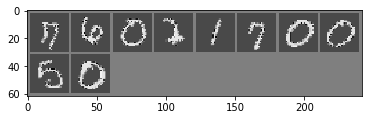

In [241]:
for data in test_loader:
    images, labels = data
    features = Variable(images.view(-1, 28*28))
    break
imshow(torchvision.utils.make_grid(images))

In [242]:
net(features).topk(1)[1]

Variable containing:
    0
    6
    0
    2
    1
    7
    0
    0
    5
    0
[torch.LongTensor of size 10x1]

In [203]:
net.accum_probs(features, 1)

[[Variable containing:
   0.3698
   0.2354
   0.4157
   0.3729
   0.2251
   0.2064
   0.4087
   0.2474
   0.2635
   0.4449
  [torch.FloatTensor of size 10x1], Variable containing:
  -2.3399 -2.1639 -2.3609 -2.2783 -2.1904 -2.4916 -2.0536 -2.3836 -2.4639 -2.3885
  -2.1216 -2.4151 -2.4126 -2.6590 -1.6693 -2.6165 -2.2584 -2.4090 -2.7313 -2.2054
  -2.4880 -2.4315 -2.4022 -2.4181 -1.8086 -2.3845 -2.6030 -2.5302 -2.6341 -1.7844
  -2.0468 -2.6011 -2.1479 -2.4624 -1.6819 -2.7388 -2.4847 -2.4772 -2.7785 -2.1664
  -2.3826 -2.1342 -2.5188 -2.6239 -1.7700 -2.5679 -2.3595 -2.4636 -2.3183 -2.1962
  -2.3078 -2.1739 -2.2567 -2.5060 -2.0410 -2.2095 -2.4665 -2.6322 -2.4764 -2.1204
  -2.3445 -2.3085 -2.1451 -2.3394 -2.0232 -2.3128 -2.3955 -2.4376 -2.6927 -2.1730
  -2.2243 -2.3504 -2.1915 -2.2503 -2.1237 -2.3369 -2.4652 -2.4607 -2.5458 -2.1678
  -2.1088 -2.3997 -2.3813 -2.4653 -1.7977 -2.5648 -2.4795 -2.3994 -2.4307 -2.2508
  -2.2055 -2.3440 -2.4924 -2.2513 -1.9905 -2.3058 -2.5462 -2.3740 -2.7144 -2.0262


In [153]:
cp[0][1]

Variable containing:
 0.5197  0.4803
[torch.FloatTensor of size 1x2]

In [154]:
criterion = nn.NLLLoss()

In [157]:
criterion(p[0][1], t)

Variable containing:
-0.4803
[torch.FloatTensor of size 1]

In [59]:
l = Leaf(20, 2)

In [60]:
l(f)

Variable containing:
 0.7010  0.2990
 0.4587  0.5413
 0.6445  0.3555
 0.6523  0.3477
 0.5520  0.4480
 0.5729  0.4271
 0.4309  0.5691
 0.6113  0.3887
 0.5364  0.4636
 0.4727  0.5273
 0.5744  0.4256
 0.4254  0.5746
 0.6120  0.3880
 0.3881  0.6119
 0.4329  0.5671
 0.6215  0.3785
 0.5566  0.4434
 0.4899  0.5101
 0.5596  0.4404
 0.4213  0.5787
 0.5454  0.4546
 0.6407  0.3593
 0.7366  0.2634
 0.5357  0.4643
 0.4664  0.5336
 0.4837  0.5163
 0.4695  0.5305
 0.3931  0.6069
 0.4598  0.5402
 0.5820  0.4180
 0.5449  0.4551
 0.5599  0.4401
 0.5203  0.4797
 0.4539  0.5461
 0.4069  0.5931
 0.4765  0.5235
 0.6093  0.3907
 0.5651  0.4349
 0.5195  0.4805
 0.7444  0.2556
 0.4269  0.5731
 0.4473  0.5527
 0.5124  0.4876
 0.4995  0.5005
 0.7357  0.2643
 0.5297  0.4703
 0.5353  0.4647
 0.5564  0.4436
 0.4799  0.5201
 0.4594  0.5406
 0.4223  0.5777
 0.6069  0.3931
 0.5184  0.4816
 0.2934  0.7066
 0.4795  0.5205
 0.4228  0.5772
 0.4746  0.5254
 0.4543  0.5457
 0.4915  0.5085
 0.7506  0.2494
 0.3913  0.6087
 0.

In [58]:
f.shape

torch.Size([100, 20])

In [25]:
n(f)

Variable containing:
 0.5568
 0.4157
 0.6472
 0.5052
 0.7840
 0.5970
 0.5989
 0.6032
 0.5259
 0.4826
 0.5710
 0.3354
 0.6097
 0.2600
 0.4450
 0.4455
 0.6031
 0.4423
 0.6174
 0.5324
 0.4664
 0.6138
 0.3941
 0.4854
 0.3821
 0.5882
 0.6332
 0.6062
 0.2798
 0.4175
 0.4970
 0.4680
 0.4224
 0.5263
 0.3459
 0.3255
 0.5238
 0.5932
 0.4105
 0.5355
 0.6300
 0.5799
 0.5868
 0.6435
 0.6820
 0.3809
 0.5247
 0.5251
 0.4482
 0.5785
 0.3621
 0.5591
 0.4758
 0.3217
 0.5141
 0.3364
 0.6387
 0.6046
 0.4159
 0.6508
 0.2434
 0.4416
 0.7236
 0.2498
 0.3928
 0.5419
 0.6580
 0.4069
 0.4864
 0.5594
 0.5003
 0.4538
 0.4237
 0.4355
 0.4910
 0.4696
 0.6194
 0.6092
 0.5075
 0.5751
 0.5980
 0.5513
 0.3349
 0.5950
 0.4625
 0.4790
 0.5537
 0.3851
 0.6574
 0.5526
 0.3472
 0.4050
 0.5815
 0.3393
 0.3553
 0.2930
 0.1914
 0.4552
 0.1965
 0.5975
[torch.FloatTensor of size 100x1]